##### 01. preparation

<b>y</b> --> correct<br>
<b>X</b> --> features

In [1]:
# import libraries

import os
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    brier_score_loss,
    roc_curve,
    precision_recall_curve,
    auc,
)
from sklearn.calibration import calibration_curve
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import RandomizedSearchCV, GroupKFold

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks

##### 02. data

In [2]:
# load ASSIST dataset
skill = pd.read_csv('data/skill_builder_data.csv', encoding='latin1') # yang ini saja yang dipakai
nonskill = pd.read_csv('data/non_skill_builder_data_new.csv', encoding='latin1')
display(skill.info())
display(nonskill.info())

C:\Users\nalin\AppData\Local\Temp\ipykernel_11536\3698619640.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  skill = pd.read_csv('data/skill_builder_data.csv', encoding='latin1') # yang ini saja yang dipakai


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525534 entries, 0 to 525533
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              525534 non-null  int64  
 1   assignment_id         525534 non-null  int64  
 2   user_id               525534 non-null  int64  
 3   assistment_id         525534 non-null  int64  
 4   problem_id            525534 non-null  int64  
 5   original              525534 non-null  int64  
 6   correct               525534 non-null  int64  
 7   attempt_count         525534 non-null  int64  
 8   ms_first_response     525534 non-null  int64  
 9   tutor_mode            525534 non-null  object 
 10  answer_type           525534 non-null  object 
 11  sequence_id           525534 non-null  int64  
 12  student_class_id      525534 non-null  int64  
 13  position              525534 non-null  int64  
 14  type                  525534 non-null  object 
 15  

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603128 entries, 0 to 603127
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              603128 non-null  int64  
 1   assignment_id         603128 non-null  int64  
 2   user_id               603128 non-null  int64  
 3   assistment_id         603128 non-null  int64  
 4   problem_id            603128 non-null  int64  
 5   original              603128 non-null  int64  
 6   correct               603128 non-null  float64
 7   attempt_count         603128 non-null  int64  
 8   ms_first_response     603120 non-null  float64
 9   tutor_mode            603128 non-null  object 
 10  answer_type           603128 non-null  object 
 11  sequence_id           603128 non-null  int64  
 12  student_class_id      603128 non-null  int64  
 13  position              603128 non-null  int64  
 14  type                  603128 non-null  object 
 15  

None

01. Dataset ini berisi log aktivitas siswa saat mengerjakan soal di platform ASSISTments, yaitu sistem pembelajaran daring untuk matematika. Data nya ada 2, yaitu data skill builder dan data non skill builder.
02. Data <b>merekam interaksi tiap siswa dengan tiap soal</b>, seperti ID siswa, ID soal, dan skill yang diuji, apakah jawabannya benar (correct), berapa kali mencoba (attempt_count), waktu pengerjaan (ms_first_response), jumlah hint yang dipakai, urutan pengerjaan soal, dll.
03. <b>Data skill builder</b> --> Data soal berbasis mastery learning; siswa berlatih sampai menguasai satu skill tertentu. Ada kolom skill_id, opportunity, cocok untuk model adaptif per-skill.
04. <b>Data non-skill builder</b> --> Data soal biasa (tidak fokus mastery); lebih variatif, tapi kadang skill_id kosong atau tidak konsisten.
05. Untuk pemodelan, <b>hanya menggunakan data skill builder

In [3]:
# yang dipakai cuma data skill aja
df = skill

##### 03. preprocess

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525534 entries, 0 to 525533
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              525534 non-null  int64  
 1   assignment_id         525534 non-null  int64  
 2   user_id               525534 non-null  int64  
 3   assistment_id         525534 non-null  int64  
 4   problem_id            525534 non-null  int64  
 5   original              525534 non-null  int64  
 6   correct               525534 non-null  int64  
 7   attempt_count         525534 non-null  int64  
 8   ms_first_response     525534 non-null  int64  
 9   tutor_mode            525534 non-null  object 
 10  answer_type           525534 non-null  object 
 11  sequence_id           525534 non-null  int64  
 12  student_class_id      525534 non-null  int64  
 13  position              525534 non-null  int64  
 14  type                  525534 non-null  object 
 15  

In [5]:
# menyiapkan kolom tipe
df = df.copy()
df['user_id'] = df['user_id'].astype(str)
df['problem_id'] = df['problem_id'].astype(str)
df['skill_id'] = df['skill_id'].fillna('unknown').astype(str)
df['correct'] = pd.to_numeric(df['correct'], errors='coerce').fillna(0).astype(int)

# waktu respons
if 'ms_first_response' in df.columns:
    df['ms_first_response'] = pd.to_numeric(df['ms_first_response'], errors='coerce').fillna(0).clip(upper=600000)
else:
    df['ms_first_response'] = 0
df['log_response_time'] = np.log1p(df['ms_first_response'])

# numeric nulls
for c in ['hint_count','hint_total','attempt_count','opportunity']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)
    else:
        df[c] = 0

# sort by user & order
if 'order_id' in df.columns:
    df = df.sort_values(['user_id','order_id']).reset_index(drop=True)
else:
    df = df.sort_values(['user_id']).reset_index(drop=True)

# make sure df sudah tersort dan index default
df = df.sort_values(['user_id','order_id']).reset_index(drop=True)

c:\Users\nalin\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# new features

# a. past_correct_skill: kumulatif benar SEBELUM baris saat ini (shift + cumsum)
df['past_correct_skill'] = df.groupby(['user_id','skill_id'])['correct'] \
                             .transform(lambda s: s.shift().fillna(0).cumsum()).astype(int)

# b. attempts_skill: jumlah percobaan sebelumnya pada (user,skill)
df['attempts_skill'] = df.groupby(['user_id','skill_id']).cumcount().astype(int)

# c. success_rate_skill: pembagian aman (hindari divide-by-zero)
df['success_rate_skill'] = df['past_correct_skill'] / df['attempts_skill'].replace(0, np.nan)
df['success_rate_skill'] = df['success_rate_skill'].fillna(0.0)

# menghitung streak benar
# seberapa lama user menjawab benar berturut-turut sebelum percobaan sekarang
def prev_streak_array(s):
    # s is a Series of correct (0/1)
    prev = s.shift().fillna(0).astype(int).to_numpy()
    out = np.empty(len(prev), dtype=np.int32)
    cur = 0
    for i, v in enumerate(prev):
        if v == 1:
            cur += 1
        else:
            cur = 0
        out[i] = cur
    return out
df['prev_streak_skill'] = df.groupby(['user_id','skill_id'])['correct'].transform(prev_streak_array).astype(int)

# mengukur tingkat kesulitan
prob_stats = df.groupby('problem_id', sort=False)['correct'].agg(['mean','count']).rename(columns={'mean':'prob_correct'})
prob_stats['difficulty_est'] = 1.0 - prob_stats['prob_correct']
# merge back
df = df.merge(prob_stats[['difficulty_est']], left_on='problem_id', right_index=True, how='left')
df['difficulty_est'] = df['difficulty_est'].fillna(0.5)

# label encoding for categorical features and save encoders
cat_cols = ['skill_id', 'problem_id']
encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c].astype(str))
    encoders[c] = le

joblib.dump(encoders, 'label_encoders.joblib')

['label_encoders.joblib']

In [7]:
# save
df.to_parquet('df_clean.parquet', index=False)
print("PREPROCESSING DONE -> df_clean.parquet saved, shape:", df.shape)

PREPROCESSING DONE -> df_clean.parquet saved, shape: (525534, 36)


##### 04. feature selection

In [8]:
df = pd.read_parquet('df_clean.parquet')

In [9]:
# candidate features
candidate_feats = [
    'skill_id','problem_id',
    'past_correct_skill','attempts_skill','success_rate_skill','prev_streak_skill',
    'hint_count','hint_total','attempt_count',
    'log_response_time','difficulty_est','opportunity'
]
candidate_feats = [f for f in candidate_feats if f in df.columns]

# sample for speed
n_sample = min(200000, len(df))
sample = df.sample(n=n_sample, random_state=42)

X = sample[candidate_feats].fillna(0)
y = sample['correct'].astype(int)

discrete = [0,1]  # adjust indices if different
mi = mutual_info_classif(X, y, discrete_features=discrete, random_state=42)
mi_series = pd.Series(mi, index=candidate_feats).sort_values(ascending=False)
print("Mutual info ranking:\n", mi_series)

# choose top k features
k = min(10, len(mi_series))
top_features = mi_series.index[:k].tolist()
print("Selected top features:", top_features)

joblib.dump(top_features, 'selected_features.joblib')

Mutual info ranking:
 attempt_count         0.259666
hint_count            0.205028
problem_id            0.189131
difficulty_est        0.154252
log_response_time     0.132526
prev_streak_skill     0.117610
success_rate_skill    0.094137
past_correct_skill    0.068596
skill_id              0.031690
hint_total            0.009117
attempts_skill        0.006839
opportunity           0.005680
dtype: float64
Selected top features: ['attempt_count', 'hint_count', 'problem_id', 'difficulty_est', 'log_response_time', 'prev_streak_skill', 'success_rate_skill', 'past_correct_skill', 'skill_id', 'hint_total']


['selected_features.joblib']

##### 05. hyperparameter tuning

In [10]:
df = pd.read_parquet('df_clean.parquet')
top_features = joblib.load('selected_features.joblib')

In [11]:
# temporal per-user split (last 10% per user -> test)
def temporal_user_split(df, test_ratio=0.1):
    train_idx, test_idx = [], []
    for uid, g in df.groupby('user_id', sort=False):
        n = len(g)
        if n <= 1:
            train_idx += list(g.index)
            continue
        n_test = max(1, int(np.ceil(n * test_ratio)))
        train_idx += list(g.index[:-n_test])
        test_idx += list(g.index[-n_test:])
    return df.loc[train_idx], df.loc[test_idx]

train_df, test_df = temporal_user_split(df, test_ratio=0.1)

X_train = train_df[top_features].fillna(0)
y_train = train_df['correct'].astype(int)

# group for CV
groups = train_df['user_id']

param_dist = {
    'n_estimators': [200,400,800],
    'learning_rate': [0.01,0.03,0.05,0.1],
    'num_leaves': [31,63,127],
    'max_depth': [-1,6,8],
    'subsample': [0.6,0.8,1.0],
    'colsample_bytree': [0.4,0.6,0.8,1.0],
    'min_child_samples': [5,10,20,50]
}

lgb = LGBMClassifier(random_state=42, n_jobs=-1)

cv = GroupKFold(n_splits=3)
rs = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_dist,
    n_iter=24,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    random_state=42
)
rs.fit(X_train, y_train, groups=groups)
print("Best params:", rs.best_params_)
joblib.dump(rs.best_estimator_, 'lgb_best.joblib')

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Number of positive: 210446, number of negative: 103629
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1749
[LightGBM] [Info] Number of data points in the train set: 314075, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.670050 -> initscore=0.708412
[LightGBM] [Info] Start training from score 0.708412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

['lgb_best.joblib']

##### 06. modelling

In [12]:


df = pd.read_parquet('df_clean.parquet')
top_features = joblib.load('selected_features.joblib')
best_lgb = joblib.load('lgb_best.joblib')

# same temporal split
def temporal_user_split(df, test_ratio=0.1):
    train_idx, test_idx = [], []
    for uid, g in df.groupby('user_id', sort=False):
        n = len(g)
        if n <= 1:
            train_idx += list(g.index)
            continue
        n_test = max(1, int(np.ceil(n * test_ratio)))
        train_idx += list(g.index[:-n_test])
        test_idx += list(g.index[-n_test:])
    return df.loc[train_idx], df.loc[test_idx]

train_df, test_df = temporal_user_split(df, test_ratio=0.1)

X_train = train_df[top_features].fillna(0)
y_train = train_df['correct'].astype(int)
X_test = test_df[top_features].fillna(0)
y_test = test_df['correct'].astype(int)

# Refit best LGB on whole training set
best_lgb.fit(X_train, y_train)
proba = best_lgb.predict_proba(X_test)[:,1]
print("LGBM AUC:", round(roc_auc_score(y_test, proba),4))
print("LogLoss:", round(log_loss(y_test, proba),4))
print("Brier:", round(brier_score_loss(y_test, proba),4))

joblib.dump(best_lgb, 'lgb_final.joblib')

# Optional: small Keras NN for .h5 (scaled features)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.joblib')

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_s.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train_s, y_train, validation_split=0.1, epochs=50, batch_size=1024, callbacks=[es], verbose=2)
# save model object to disk? do in step 6
joblib.dump({'X_test':X_test, 'y_test':y_test}, 'eval_data.joblib')
joblib.dump(model, 'keras_model_obj.joblib')  # pickled keras object (if in same session)


[LightGBM] [Info] Number of positive: 319194, number of negative: 151919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 471113, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677532 -> initscore=0.742452
[LightGBM] [Info] Start training from score 0.742452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

['keras_model_obj.joblib']

##### 07. evaluation

Saved: roc_curve.png, pr_curve.png, calibration.png


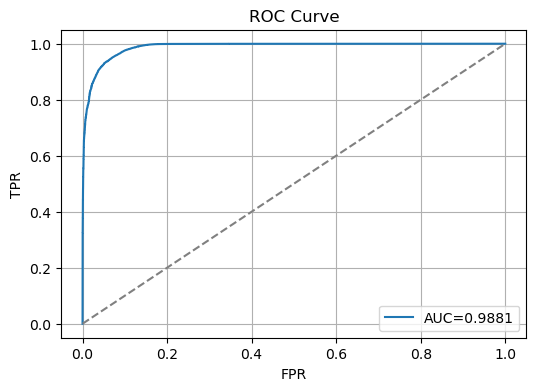

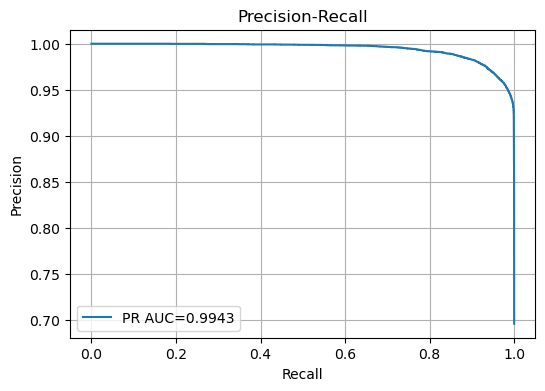

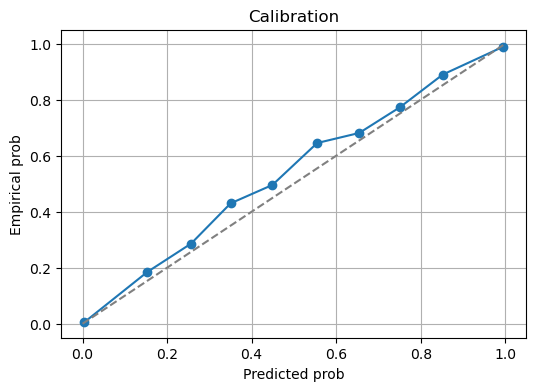

In [13]:


lgb = joblib.load('lgb_final.joblib')
edata = joblib.load('eval_data.joblib')
X_test = edata['X_test']
y_test = edata['y_test']

proba = lgb.predict_proba(X_test)[:,1]

# ROC
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.4f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.grid(True)
plt.savefig('roc_curve.png', dpi=150)

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, proba)
pr_auc = auc(rec, prec)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f'PR AUC={pr_auc:.4f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall'); plt.legend(); plt.grid(True)
plt.savefig('pr_curve.png', dpi=150)

# Calibration
prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('Predicted prob'); plt.ylabel('Empirical prob'); plt.title('Calibration'); plt.grid(True)
plt.savefig('calibration.png', dpi=150)

print("Saved: roc_curve.png, pr_curve.png, calibration.png")


##### 08. save model

In [14]:
# save_model_h5.py
try:
    keras_obj = joblib.load('keras_model_obj.joblib')
    # keras model saved via joblib may not be reliable cross-session. If it's a keras Model:
    keras_obj.save('adaptive_nn_model.h5')
    print("Saved adaptive_nn_model.h5")
except Exception as e:
    print("Could not load pickled keras model - if you are in a new session, re-train the Keras model in step 4 and then save it.")
    
# ensure LGBM final exists
lgb = joblib.load('lgb_final.joblib')
joblib.dump(lgb, 'lgb_final.joblib')
print("LGBM saved as lgb_final.joblib")

Saved adaptive_nn_model.h5
LGBM saved as lgb_final.joblib


c:\Users\nalin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# show
model = joblib.load('lgb_final.joblib')
top_features = joblib.load('selected_features.joblib')
df = pd.read_parquet('df_clean.parquet')

# ambil 1 contoh baris input
sample = df[top_features].iloc[[0]]

# tampilkan kolom fitur dan nilainya
print("=== Fitur Input (X) ===")
for col, val in sample.iloc[0].items():
    print(f"{col:25s}: {val}")

# prediksi probabilitas benar
proba = model.predict_proba(sample)[:, 1][0]

# tampilkan hasil prediksi
print("\nPrediksi probabilitas benar (P(correct=1)):", format(proba, '.10f'))

=== Fitur Input (X) ===
attempt_count            : 1.0
hint_count               : 2.0
problem_id               : 24826.0
difficulty_est           : 0.5833333333333333
log_response_time        : 10.176259012252155
prev_streak_skill        : 0.0
success_rate_skill       : 0.0
past_correct_skill       : 0.0
skill_id                 : 21.0
hint_total               : 2.0

Prediksi probabilitas benar (P(correct=1)): 0.0000361677


: 